In [1]:
# Cell 1: Imports and Setup
# This cell sets up the environment for plotting learning curves

import json
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

# Paths
API_DIR = Path("/Users/thefool/Local/Project/WebMining/Books/app/backend/api")
CHECKPOINTS_DIR = API_DIR / "checkpoints"

print(f"Checkpoints directory: {CHECKPOINTS_DIR}")
print(f"Available models: {[d.name for d in CHECKPOINTS_DIR.iterdir() if d.is_dir()]}")


Checkpoints directory: /Users/thefool/Local/Project/WebMining/Books/app/backend/api/checkpoints
Available models: ['mf', 'lightgcn', 'bivae', 'bpr']


In [ ]:
# Cell 2: Load all model metrics
# This cell loads metrics.json from each model checkpoint

def load_model_metrics(model_name: str) -> dict:
    """Load metrics from a model's checkpoint directory."""
    metrics_path = CHECKPOINTS_DIR / model_name / "metrics.json"
    if metrics_path.exists():
        with open(metrics_path) as f:
            return json.load(f)
    return {}


# Load all metrics
models = ["mf", "bpr", "bivae", "lightgcn"]
all_metrics = {}

for model in models:
    metrics = load_model_metrics(model)
    if metrics:
        all_metrics[model] = metrics
        print(f"Loaded {model}: {list(metrics.keys())}")
    else:
        print(f"No metrics found for {model}")

print(f"\nLoaded {len(all_metrics)} models")


Loaded mf: ['train_time', 'final_precision', 'final_recall', 'n_epochs', 'n_factors', 'learning_curve']
Loaded bpr: ['train_time', 'final_precision', 'final_recall', 'n_epochs']
Loaded bivae: ['train_time', 'final_precision', 'final_recall', 'n_epochs']
Loaded lightgcn: ['train_time', 'final_precision', 'final_recall', 'n_epochs', 'learning_curve']
No metrics found for lightfm

Loaded 4 models


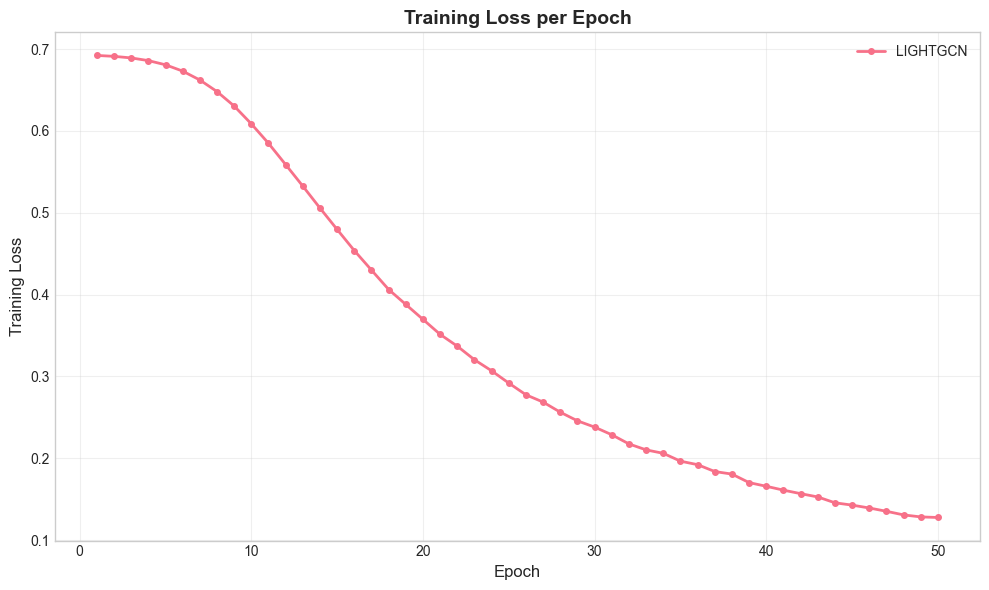

Saved to /Users/thefool/Local/Project/WebMining/Books/app/backend/api/checkpoints/learning_curves_loss.png


In [5]:
# Cell 3: Plot Learning Curves (Training Loss)
# This cell plots training loss per epoch for models that track it

fig, ax = plt.subplots(figsize=(10, 6))

for model_name, metrics in all_metrics.items():
    if "learning_curve" in metrics:
        curve = metrics["learning_curve"]
        epochs = curve.get("epochs", [])

        # Try different loss keys
        loss = curve.get("train_loss", curve.get("train_rmse", []))

        if epochs and loss:
            ax.plot(epochs, loss, marker='o', markersize=4, label=model_name.upper(), linewidth=2)

ax.set_xlabel("Epoch", fontsize=12)
ax.set_ylabel("Training Loss", fontsize=12)
ax.set_title("Training Loss per Epoch", fontsize=14, fontweight='bold')
ax.legend(loc='upper right', fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(CHECKPOINTS_DIR / "learning_curves_loss.png", dpi=150, bbox_inches='tight')
plt.show()

print(f"Saved to {CHECKPOINTS_DIR / 'learning_curves_loss.png'}")


   Model  Precision@10  Recall@10  Train Time (s)
LIGHTGCN      0.017508   0.080314       17.340905
     BPR      0.010101   0.045315        1.681081
   BIVAE      0.006734   0.029213       20.159583
      MF      0.004714   0.019080        0.462534


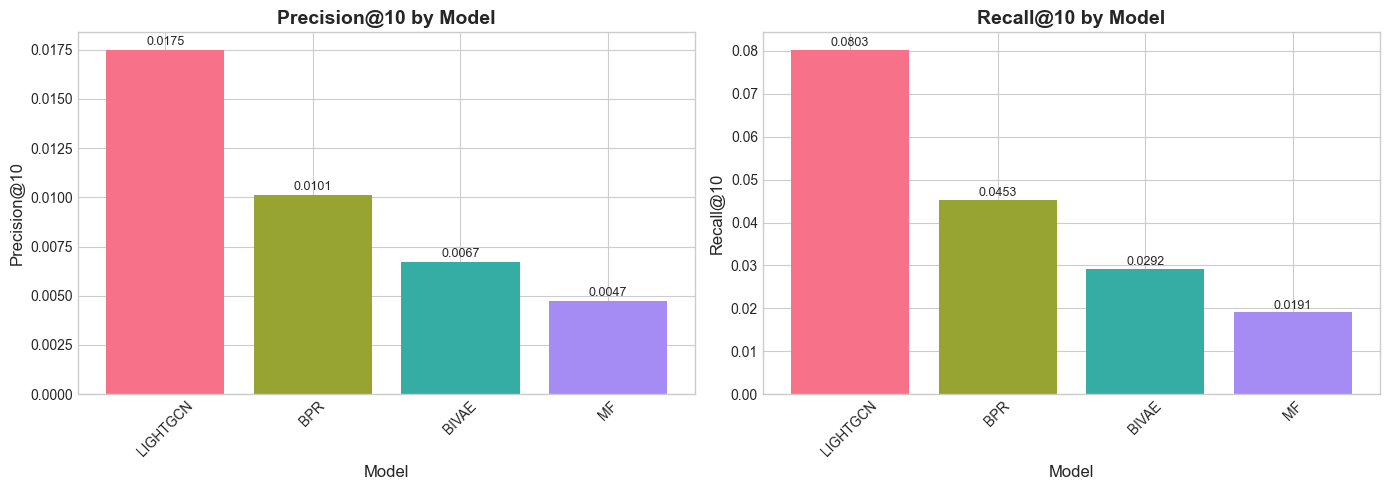

Saved to /Users/thefool/Local/Project/WebMining/Books/app/backend/api/checkpoints/model_comparison_metrics.png


In [7]:
# Cell 4: Model Performance Comparison Bar Chart
# This cell creates a bar chart comparing Precision@10 and Recall@10 across models

# Prepare data
comparison_data = []
for model_name, metrics in all_metrics.items():
    comparison_data.append({
        "Model": model_name.upper(),
        "Precision@10": metrics.get("final_precision", metrics.get("eval_metrics", {}).get("precision@10", 0)),
        "Recall@10": metrics.get("final_recall", metrics.get("eval_metrics", {}).get("recall@10", 0)),
        "Train Time (s)": metrics.get("train_time", metrics.get("train_history", {}).get("train_time_seconds", 0)),
    })

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values("Precision@10", ascending=False)

print(comparison_df.to_string(index=False))

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Precision
ax1 = axes[0]
bars1 = ax1.bar(comparison_df["Model"], comparison_df["Precision@10"], color=sns.color_palette("husl", len(comparison_df)))
ax1.set_xlabel("Model", fontsize=12)
ax1.set_ylabel("Precision@10", fontsize=12)
ax1.set_title("Precision@10 by Model", fontsize=14, fontweight='bold')
ax1.tick_params(axis='x', rotation=45)

# Add value labels
for bar, val in zip(bars1, comparison_df["Precision@10"]):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.0001,
             f'{val:.4f}', ha='center', va='bottom', fontsize=9)

# Recall
ax2 = axes[1]
bars2 = ax2.bar(comparison_df["Model"], comparison_df["Recall@10"], color=sns.color_palette("husl", len(comparison_df)))
ax2.set_xlabel("Model", fontsize=12)
ax2.set_ylabel("Recall@10", fontsize=12)
ax2.set_title("Recall@10 by Model", fontsize=14, fontweight='bold')
ax2.tick_params(axis='x', rotation=45)

# Add value labels
for bar, val in zip(bars2, comparison_df["Recall@10"]):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.0001,
             f'{val:.4f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig(CHECKPOINTS_DIR / "model_comparison_metrics.png", dpi=150, bbox_inches='tight')
plt.show()

print(f"Saved to {CHECKPOINTS_DIR / 'model_comparison_metrics.png'}")


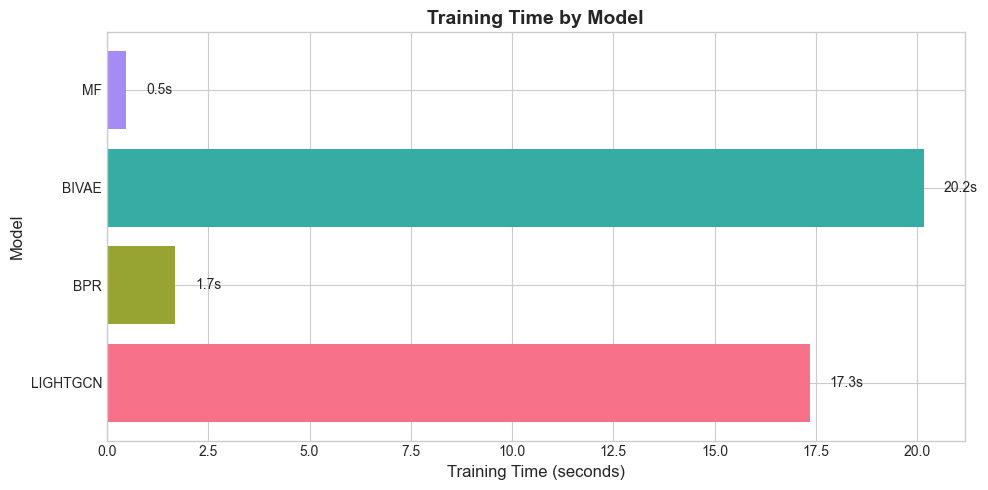

Saved to /Users/thefool/Local/Project/WebMining/Books/app/backend/api/checkpoints/training_time_comparison.png


In [8]:
# Cell 5: Training Time Comparison
# This cell compares training time across models

fig, ax = plt.subplots(figsize=(10, 5))

colors = sns.color_palette("husl", len(comparison_df))
bars = ax.barh(comparison_df["Model"], comparison_df["Train Time (s)"], color=colors)

ax.set_xlabel("Training Time (seconds)", fontsize=12)
ax.set_ylabel("Model", fontsize=12)
ax.set_title("Training Time by Model", fontsize=14, fontweight='bold')

# Add value labels
for bar, val in zip(bars, comparison_df["Train Time (s)"]):
    ax.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2,
            f'{val:.1f}s', ha='left', va='center', fontsize=10)

plt.tight_layout()
plt.savefig(CHECKPOINTS_DIR / "training_time_comparison.png", dpi=150, bbox_inches='tight')
plt.show()

print(f"Saved to {CHECKPOINTS_DIR / 'training_time_comparison.png'}")


MODEL RANKING (by Precision@10)
 Rank    model  precision@10  recall@10
    1 LightGCN      0.017508   0.080314
    2  LightFM      0.011785   0.043816
    3      BPR      0.010101   0.045315
    4    BiVAE      0.006734   0.029213
    5       MF      0.004714   0.019080


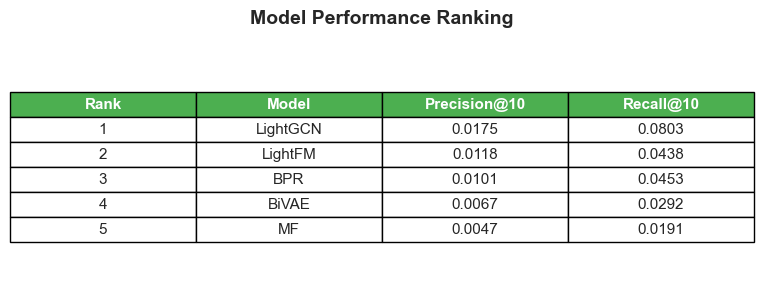


Saved to /Users/thefool/Local/Project/WebMining/Books/app/backend/api/checkpoints/model_ranking_table.png


In [13]:
# Cell 6: Summary Table
# This cell creates and displays a summary table of all results

# Load comparison CSV
comparison_csv = CHECKPOINTS_DIR / "model_comparison.csv"
if comparison_csv.exists():
    results_df = pd.read_csv(comparison_csv)
    results_df = results_df.sort_values("precision@10", ascending=False)
    results_df["Rank"] = range(1, len(results_df) + 1)

    print("=" * 60)
    print("MODEL RANKING (by Precision@10)")
    print("=" * 60)
    print(results_df[["Rank", "model", "precision@10", "recall@10"]].to_string(index=False))
else:
    print("No comparison CSV found. Run training first.")

# Create styled table for display
fig, ax = plt.subplots(figsize=(8, 3))
ax.axis('tight')
ax.axis('off')

table_data = results_df[["Rank", "model", "precision@10", "recall@10"]].values.tolist()
for i in range(len(table_data)):
    for j in range(len(table_data[i])):
        if isinstance(table_data[i][j], float):
            table_data[i][j] = f"{table_data[i][j]:.4f}"
headers = ["Rank", "Model", "Precision@10", "Recall@10"]

table = ax.table(
    cellText=table_data,
    colLabels=headers,
    cellLoc='center',
    loc='center',
    colColours=['#4CAF50'] * 4,
)

table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1.2, 1.5)

# Style header
for (row, col), cell in table.get_celld().items():
    if row == 0:
        cell.set_text_props(weight='bold', color='white')

plt.title("Model Performance Ranking", fontsize=14, fontweight='bold', pad=20)
plt.savefig(CHECKPOINTS_DIR / "model_ranking_table.png", dpi=150, bbox_inches='tight')
plt.show()

print(f"\nSaved to {CHECKPOINTS_DIR / 'model_ranking_table.png'}")
